In [1]:
!pip install pytorch_forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [2]:
# from pytorch_forecasting.models.nbeats import NBeats
from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE
from pytorch_forecasting.data.encoders import NaNLabelEncoder
import pandas as pd
import numpy as np
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [3]:
# Đọc dữ liệu
data = pd.read_csv('REGN_processed.csv')
# Convert 'Date' to datetime và sort
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

# Giữ lại bản sao của cột ngày gốc
original_dates = data['Date'].copy()

# Chuyển đổi ngày thành chỉ số số nguyên
data['Date'] = np.arange(0, data.shape[0])
data['series'] = 0  # single series

In [4]:
# Parameters
max_encoder_length = 180
def prepare_data(data, split_ratio, max_encoder_length):
  # Split data into train and test sets based on a 80/20 ratio
  train_size = int(len(data) * split_ratio)

  train_data = data.iloc[:train_size]
  test_data = data.iloc[train_size - max_encoder_length:]  # Include overlap for encoder length
  return train_data, test_data, train_size

In [5]:
# Load the best model
def train_nbeats_model(train_data, test_data, max_prediction_length, train_size, max_encoder_length):
  # Create TimeSeriesDataSet for training
  training = TimeSeriesDataSet(
      train_data,
      time_idx="Date",
      target="Adj Close",
      categorical_encoders={"series": NaNLabelEncoder().fit(train_data.series)},
      group_ids=["series"],
      time_varying_unknown_reals=["Adj Close"],
      max_encoder_length=max_encoder_length,
      max_prediction_length=max_prediction_length,
  )

  # Create TimeSeriesDataSet for testing
  testing = TimeSeriesDataSet.from_dataset(training, test_data, min_prediction_idx=train_size)

  # DataLoader
  batch_size = 32
  train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=3)
  test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=3)

  # Trainer setup
  early_stop_callback = EarlyStopping(monitor="train_loss_epoch", min_delta=1e-4, patience=10, verbose=False, mode="min")
  trainer = pl.Trainer(
      max_epochs=30,
      accelerator="auto",
      enable_model_summary=True,
      gradient_clip_val=0.01,
      log_every_n_steps=10,
      limit_train_batches=150,
      callbacks=[early_stop_callback]
  )

  # Initialize NBeats model
  net = NBeats.from_dataset(
      training,
      learning_rate=1e-3,
      log_interval=10,
      log_val_interval=1,
      weight_decay=1e-2,
      widths=[32, 512],
      backcast_loss_ratio=1.0,
  )

  # Train the model
  trainer.fit(
      net,
      train_dataloaders=train_dataloader,
  )

  # Load the best model
  best_model_path = trainer.checkpoint_callback.best_model_path
  best_model = NBeats.load_from_checkpoint(best_model_path)
  return best_model, test_dataloader, training



In [6]:
def evaluate_model(best_model, test_data, test_dataloader, max_prediction_length, train_size):
  # Make predictions on the test set
  predictions = best_model.predict(test_dataloader)

  # Extract true values for comparison
  true_values = test_data.loc[test_data['Date'] >= train_size, 'Adj Close'].values[:max_prediction_length]

  # Flatten the predicted values
  predicted_values = predictions.numpy().flatten()[:len(true_values)]

  # Calculate RMSE
  rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
  print(f"RMSE on test set: {rmse}")

  # Calculate MAE
  mae = mean_absolute_error(true_values, predicted_values)
  print(f"MAE on test set: {mae}")

  # Calculate MAPE
  mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
  print(f"MAPE on test set: {mape}")

  # Convert predictions to a DataFrame for comparison
  test_dates = original_dates.iloc[train_size:train_size + max_prediction_length]
  predicted_df = pd.DataFrame({"Date": test_dates, "Predicted Price": predicted_values})

  # Extract true values to DataFrame for comparison
  true_df = pd.DataFrame({"Date": test_dates, "True Price": true_values})

  # Merge predictions and true values for evaluation
  evaluation_df = pd.merge(predicted_df, true_df, on="Date")
  return evaluation_df


In [7]:
# Function to make future predictions
def predict_nbeats_model(best_model, training, data, max_prediction_length):
    # Prepare data for prediction
    last_data = data.tail(max_encoder_length).copy()
    last_data_dates = np.arange(len(data), len(data) + max_prediction_length)

    # Forward fill the Adj Close column for future dates
    future_data = pd.DataFrame({
        'Date': last_data_dates,
        'series': 0,
        'Adj Close': [last_data['Adj Close'].iloc[-1]] * max_prediction_length  # forward fill with last known value
    })

    # Combine the last data with the future data
    prediction_data = pd.concat([last_data, future_data], ignore_index=True)

    # Create a TimeSeriesDataSet for prediction
    prediction_dataset = TimeSeriesDataSet.from_dataset(
        training,
        prediction_data,
        min_prediction_idx=last_data_dates[0]
    )

    # Create DataLoader for prediction
    prediction_dataloader = prediction_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)

    # Make predictions
    predictions = best_model.predict(prediction_dataloader)

    # Convert predictions to a DataFrame
    last_date = original_dates.max()
    predicted_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=max_prediction_length)
    predicted_prices = predictions.numpy().flatten()
    future_df = pd.DataFrame({"Date": predicted_dates, "Predicted Price": predicted_prices})

    return future_df

# **Train Test 8/2**

**Predict next 30 days**

In [9]:
max_prediction_length = 30

train_data_30, test_data_30, train_size_30 = prepare_data(data, 0.8, max_encoder_length)
best_model_30, test_dataloader_30, training30 = train_nbeats_model(train_data_30, test_data_30, max_prediction_length, train_size_30, max_encoder_length)

evaluation_df30 = evaluate_model(best_model_30, test_data_30 ,test_dataloader_30, max_prediction_length, train_size_30)
print(evaluation_df30)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


RMSE on test set: 87.96583100583811
MAE on test set: 70.40388240559895
MAPE on test set: 8.88963974631853
         Date  Predicted Price  True Price
0  2023-03-01       757.625366      770.44
1  2023-03-02       755.911560      768.90
2  2023-03-03       752.824463      779.30
3  2023-03-04       749.173401      779.66
4  2023-03-05       745.351501      780.02
5  2023-03-06       741.436584      780.38
6  2023-03-07       737.531494      773.85
7  2023-03-08       733.966248      745.20
8  2023-03-09       731.128540      743.75
9  2023-03-10       729.035400      747.00
10 2023-03-11       727.029236      748.78
11 2023-03-12       723.952393      750.55
12 2023-03-13       718.808105      752.33
13 2023-03-14       711.510559      766.80
14 2023-03-15       703.169556      760.30
15 2023-03-16       695.615112      749.75
16 2023-03-17       690.377869      747.65
17 2023-03-18       687.765503      751.52
18 2023-03-19       686.666199      755.38
19 2023-03-20       685.255859    

In [10]:
future_df30 = predict_nbeats_model(best_model_30, training30, data, max_prediction_length)
print(future_df30)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


         Date  Predicted Price
0  2024-03-01       985.335022
1  2024-03-02       985.778870
2  2024-03-03       984.552734
3  2024-03-04       983.291687
4  2024-03-05       982.012878
5  2024-03-06       979.719238
6  2024-03-07       975.677002
7  2024-03-08       970.261841
8  2024-03-09       964.745911
9  2024-03-10       960.304810
10 2024-03-11       957.133423
11 2024-03-12       954.417969
12 2024-03-13       951.166626
13 2024-03-14       947.182434
14 2024-03-15       943.339600
15 2024-03-16       940.899475
16 2024-03-17       940.403198
17 2024-03-18       941.062805
18 2024-03-19       941.212952
19 2024-03-20       939.553467
20 2024-03-21       936.249878
21 2024-03-22       933.005066
22 2024-03-23       931.956848
23 2024-03-24       934.156128
24 2024-03-25       938.742737
25 2024-03-26       943.473206
26 2024-03-27       946.277283
27 2024-03-28       946.754883
28 2024-03-29       946.532227
29 2024-03-30       948.193726


**Predict for next 60 days**

In [11]:
max_prediction_length = 60

train_data_60, test_data_60, train_size_60 = prepare_data(data, 0.8, max_encoder_length)
best_model_60, test_dataloader_60, training60 = train_nbeats_model(train_data_60, test_data_60, max_prediction_length, train_size_60, max_encoder_length)

evaluation_df60 = evaluate_model(best_model_60, test_data_60 ,test_dataloader_60, max_prediction_length, train_size_60)
print(evaluation_df60)
future_df60 = predict_nbeats_model(best_model_60, training60, data, max_prediction_length)
print(future_df60)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU ava

RMSE on test set: 111.19012427526248
MAE on test set: 99.96422294108073
MAPE on test set: 12.380386161753501
         Date  Predicted Price  True Price
0  2023-03-01       749.107605      770.44
1  2023-03-02       749.953796      768.90
2  2023-03-03       748.174438      779.30
3  2023-03-04       743.020386      779.66
4  2023-03-05       735.725220      780.02
5  2023-03-06       728.734497      780.38
6  2023-03-07       724.255859      773.85
7  2023-03-08       723.064636      745.20
8  2023-03-09       724.262756      743.75
9  2023-03-10       726.027771      747.00
10 2023-03-11       726.764587      748.78
11 2023-03-12       725.887451      750.55
12 2023-03-13       723.802002      752.33
13 2023-03-14       721.245972      766.80
14 2023-03-15       718.562988      760.30
15 2023-03-16       715.456055      749.75
16 2023-03-17       711.351807      747.65
17 2023-03-18       706.037231      751.52
18 2023-03-19       700.037781      755.38
19 2023-03-20       694.426514 

In [9]:
max_prediction_length = 90

train_data_90, test_data_90, train_size_90 = prepare_data(data, 0.8, max_encoder_length)
best_model_90, test_dataloader_90, training90 = train_nbeats_model(train_data_90, test_data_90, max_prediction_length, train_size_90, max_encoder_length)

evaluation_df90 = evaluate_model(best_model_90, test_data_90 ,test_dataloader_90, max_prediction_length, train_size_90)
print(evaluation_df90)
future_df90 = predict_nbeats_model(best_model_90, training90, data, max_prediction_length)
print(future_df90)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU ava

RMSE on test set: 119.3929326939105
MAE on test set: 110.26419867621524
MAPE on test set: 13.990202582276002
         Date  Predicted Price  True Price
0  2023-03-01       748.284058      770.44
1  2023-03-02       747.925659      768.90
2  2023-03-03       748.887207      779.30
3  2023-03-04       750.228027      779.66
4  2023-03-05       750.175720      780.02
..        ...              ...         ...
85 2023-05-25       639.808105      725.00
86 2023-05-26       634.887085      725.05
87 2023-05-27       625.895813      725.94
88 2023-05-28       618.302002      726.82
89 2023-05-29       619.583008      727.71

[90 rows x 3 columns]
         Date  Predicted Price
0  2024-03-01       983.956665
1  2024-03-02       984.854309
2  2024-03-03       987.227661
3  2024-03-04       989.382141
4  2024-03-05       989.404846
..        ...              ...
85 2024-05-25      1149.309204
86 2024-05-26      1152.799316
87 2024-05-27      1157.774902
88 2024-05-28      1158.445557
89 2024-05-

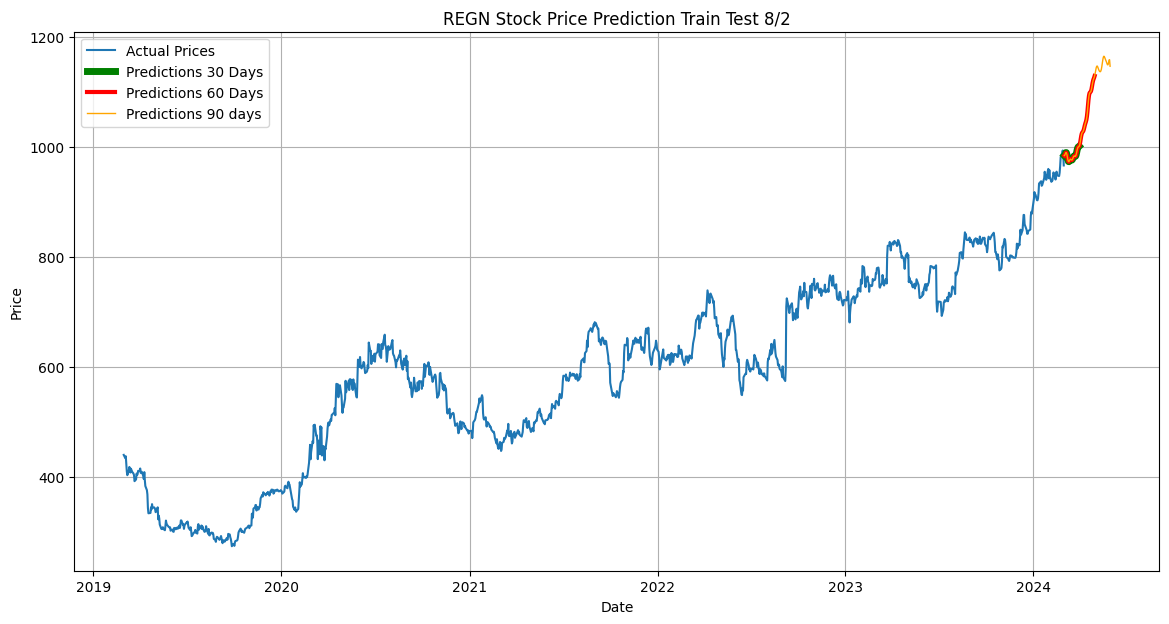

In [10]:
import matplotlib.pyplot as plt
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(original_dates, data['Adj Close'], label='Actual Prices')
plt.plot(future_df90['Date'].iloc[:30], future_df90['Predicted Price'].iloc[:30], label='Predictions 30 Days', color='green', linestyle='-', linewidth=5)
plt.plot(future_df90['Date'].iloc[:60], future_df90['Predicted Price'].iloc[:60], label='Predictions 60 Days', color='red', linestyle='-', linewidth=3)
plt.plot(future_df90['Date'], future_df90['Predicted Price'], label='Predictions 90 days', color='orange', linestyle='-', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('REGN Stock Price Prediction Train Test 8/2')
plt.legend()
plt.grid(True)
plt.show()

# **Train Test 7/3**

**Predict next 30 days**

In [14]:
max_prediction_length = 30

train_data_30, test_data_30, train_size_30 = prepare_data(data, 0.7, max_encoder_length)
best_model_30, test_dataloader_30, training30 = train_nbeats_model(train_data_30, test_data_30, max_prediction_length, train_size_30, max_encoder_length)

evaluation_df30 = evaluate_model(best_model_30, test_data_30 ,test_dataloader_30, max_prediction_length, train_size_30)
print(evaluation_df30)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


RMSE on test set: 106.81067983672908
MAE on test set: 95.97536352539063
MAPE on test set: 13.885934256103619
         Date  Predicted Price  True Price
0  2022-08-30       614.657654      588.39
1  2022-08-31       619.207031      581.06
2  2022-09-01       620.427612      600.63
3  2022-09-02       618.183655      580.62
4  2022-09-03       613.621704      578.96
5  2022-09-04       608.368469      577.29
6  2022-09-05       603.794373      575.63
7  2022-09-06       600.667908      573.97
8  2022-09-07       599.178345      596.44
9  2022-09-08       599.098938      708.85
10 2022-09-09       599.908264      724.32
11 2022-09-10       600.864746      719.79
12 2022-09-11       601.143066      715.27
13 2022-09-12       600.087280      710.74
14 2022-09-13       597.481873      701.39
15 2022-09-14       593.653503      697.62
16 2022-09-15       589.296692      705.85
17 2022-09-16       585.116089      710.30
18 2022-09-17       581.519958      711.98
19 2022-09-18       578.557373 

In [15]:
future_df30 = predict_nbeats_model(best_model_30, training30, data, max_prediction_length)
print(future_df30)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


         Date  Predicted Price
0  2024-03-01       985.046021
1  2024-03-02       987.887207
2  2024-03-03       987.380981
3  2024-03-04       986.254517
4  2024-03-05       985.643616
5  2024-03-06       984.829712
6  2024-03-07       982.381165
7  2024-03-08       977.637390
8  2024-03-09       971.355103
9  2024-03-10       965.110168
10 2024-03-11       960.054749
11 2024-03-12       956.104919
12 2024-03-13       952.218506
13 2024-03-14       947.505310
14 2024-03-15       942.217102
15 2024-03-16       937.760254
16 2024-03-17       935.667114
17 2024-03-18       936.330261
18 2024-03-19       938.539246
19 2024-03-20       940.263855
20 2024-03-21       940.148926
21 2024-03-22       938.591614
22 2024-03-23       937.539978
23 2024-03-24       939.106689
24 2024-03-25       944.009583
25 2024-03-26       951.018066
26 2024-03-27       957.848389
27 2024-03-28       962.847778
28 2024-03-29       966.184937
29 2024-03-30       969.604614


**Predict for next 60 days**

In [16]:
max_prediction_length = 60

train_data_60, test_data_60, train_size_60 = prepare_data(data, 0.7, max_encoder_length)
best_model_60, test_dataloader_60, training60 = train_nbeats_model(train_data_60, test_data_60, max_prediction_length, train_size_60, max_encoder_length)

evaluation_df60 = evaluate_model(best_model_60, test_data_60 ,test_dataloader_60, max_prediction_length, train_size_60)
print(evaluation_df60)
future_df60 = predict_nbeats_model(best_model_60, training60, data, max_prediction_length)
print(future_df60)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU ava

RMSE on test set: 126.61476126165893
MAE on test set: 119.42498701985677
MAPE on test set: 16.779103928595582
         Date  Predicted Price  True Price
0  2022-08-30       611.563538      588.39
1  2022-08-31       618.558594      581.06
2  2022-09-01       624.390625      600.63
3  2022-09-02       628.199585      580.62
4  2022-09-03       629.485229      578.96
5  2022-09-04       628.287598      577.29
6  2022-09-05       625.276062      575.63
7  2022-09-06       621.524414      573.97
8  2022-09-07       617.999329      596.44
9  2022-09-08       615.074707      708.85
10 2022-09-09       612.435913      724.32
11 2022-09-10       609.483948      719.79
12 2022-09-11       605.963135      715.27
13 2022-09-12       602.329590      710.74
14 2022-09-13       599.540833      701.39
15 2022-09-14       598.381958      697.62
16 2022-09-15       598.820251      705.85
17 2022-09-16       599.907715      710.30
18 2022-09-17       600.362366      711.98
19 2022-09-18       599.438965

**Predict for next 90 days**

In [11]:
max_prediction_length = 90

train_data_90, test_data_90, train_size_90 = prepare_data(data, 0.7, max_encoder_length)
best_model_90, test_dataloader_90, training90 = train_nbeats_model(train_data_90, test_data_90, max_prediction_length, train_size_90, max_encoder_length)

evaluation_df90 = evaluate_model(best_model_90, test_data_90 ,test_dataloader_90, max_prediction_length, train_size_90)
print(evaluation_df90)
future_df90 = predict_nbeats_model(best_model_90, training90, data, max_prediction_length)
print(future_df90.head(90))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available: False, u

RMSE on test set: 164.09277847784568
MAE on test set: 153.8313480360243
MAPE on test set: 21.169977394737284
         Date  Predicted Price  True Price
0  2022-08-30       612.452698      588.39
1  2022-08-31       607.351624      581.06
2  2022-09-01       602.057739      600.63
3  2022-09-02       599.560669      580.62
4  2022-09-03       601.452637      578.96
..        ...              ...         ...
85 2022-11-23       517.522949      735.36
86 2022-11-24       515.532166      735.79
87 2022-11-25       516.155579      736.23
88 2022-11-26       522.194763      737.98
89 2022-11-27       534.971558      739.73

[90 rows x 3 columns]
         Date  Predicted Price
0  2024-03-01       987.972717
1  2024-03-02       984.862122
2  2024-03-03       980.830627
3  2024-03-04       977.672485
4  2024-03-05       976.782776
..        ...              ...
85 2024-05-25      1160.884888
86 2024-05-26      1167.417969
87 2024-05-27      1172.336060
88 2024-05-28      1168.808960
89 2024-05-

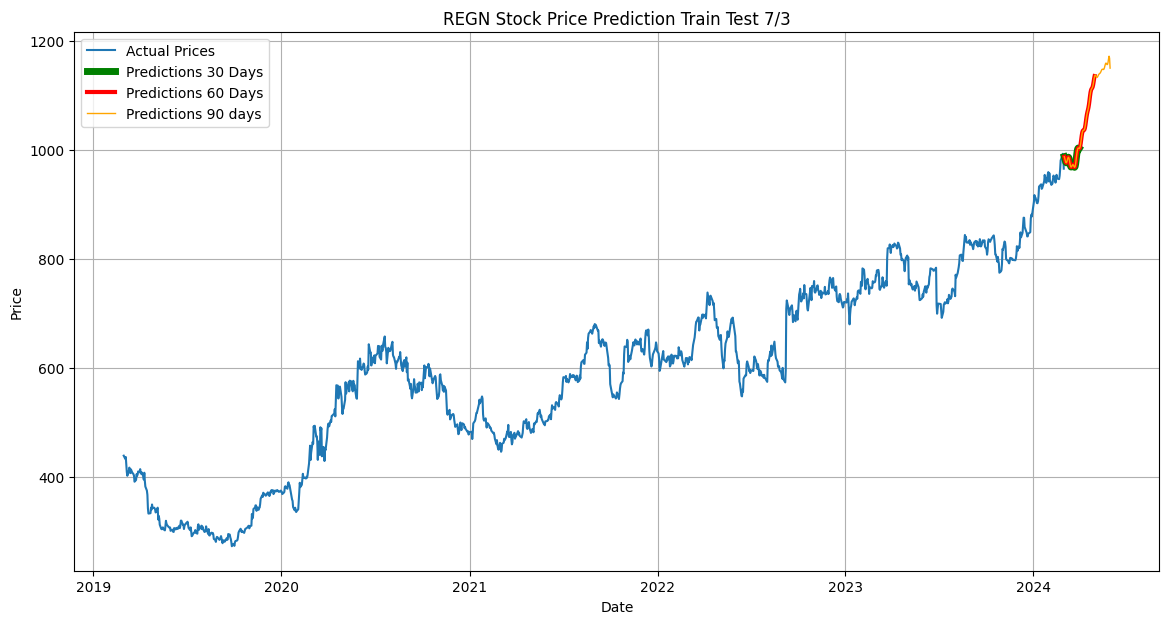

In [12]:
import matplotlib.pyplot as plt
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(original_dates, data['Adj Close'], label='Actual Prices')
plt.plot(future_df90['Date'].iloc[:30], future_df90['Predicted Price'].iloc[:30], label='Predictions 30 Days', color='green', linestyle='-', linewidth=5)
plt.plot(future_df90['Date'].iloc[:60], future_df90['Predicted Price'].iloc[:60], label='Predictions 60 Days', color='red', linestyle='-', linewidth=3)
plt.plot(future_df90['Date'], future_df90['Predicted Price'], label='Predictions 90 days', color='orange', linestyle='-', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('REGN Stock Price Prediction Train Test 7/3')
plt.legend()
plt.grid(True)
plt.show()

# **Train Test 6/4**

**Predict next 30 days**

In [19]:
max_prediction_length = 30

train_data_30, test_data_30, train_size_30 = prepare_data(data, 0.6, max_encoder_length)
best_model_30, test_dataloader_30, training30 = train_nbeats_model(train_data_30, test_data_30, max_prediction_length, train_size_30, max_encoder_length)

evaluation_df30 = evaluate_model(best_model_30, test_data_30 ,test_dataloader_30, max_prediction_length, train_size_30)
print(evaluation_df30)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


RMSE on test set: 17.581530119870017
MAE on test set: 13.89813167317709
MAPE on test set: 2.1919706363340015
         Date  Predicted Price  True Price
0  2022-03-01       635.805969      607.03
1  2022-03-02       640.662415      616.87
2  2022-03-03       643.864197      611.15
3  2022-03-04       644.669556      620.41
4  2022-03-05       643.627197      619.80
5  2022-03-06       642.321167      619.20
6  2022-03-07       642.533630      618.59
7  2022-03-08       645.330017      614.74
8  2022-03-09       650.575806      623.43
9  2022-03-10       657.096008      630.36
10 2022-03-11       663.303589      642.58
11 2022-03-12       667.914062      647.19
12 2022-03-13       670.415894      651.80
13 2022-03-14       671.173340      656.41
14 2022-03-15       671.221741      665.93
15 2022-03-16       671.869812      677.98
16 2022-03-17       674.200195      685.23
17 2022-03-18       678.570618      685.94
18 2022-03-19       684.293701      688.36
19 2022-03-20       689.729431 

In [20]:
future_df30 = predict_nbeats_model(best_model_30, training30, data, max_prediction_length)
print(future_df30)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


         Date  Predicted Price
0  2024-03-01       982.694702
1  2024-03-02       987.212891
2  2024-03-03       988.633728
3  2024-03-04       988.604370
4  2024-03-05       988.547363
5  2024-03-06       988.922791
6  2024-03-07       989.267151
7  2024-03-08       988.834412
8  2024-03-09       987.304749
9  2024-03-10       985.070923
10 2024-03-11       982.971069
11 2024-03-12       981.728943
12 2024-03-13       981.518555
13 2024-03-14       981.924500
14 2024-03-15       982.264526
15 2024-03-16       982.013000
16 2024-03-17       981.048584
17 2024-03-18       979.616699
18 2024-03-19       978.099792
19 2024-03-20       976.779602
20 2024-03-21       975.724854
21 2024-03-22       974.824219
22 2024-03-23       973.900879
23 2024-03-24       972.843079
24 2024-03-25       971.715454
25 2024-03-26       970.828674
26 2024-03-27       970.720764
27 2024-03-28       971.992554
28 2024-03-29       974.997986
29 2024-03-30       979.511719


**Predict for next 60 days**

In [21]:
max_prediction_length = 60

train_data_60, test_data_60, train_size_60 = prepare_data(data, 0.6, max_encoder_length)
best_model_60, test_dataloader_60, training60 = train_nbeats_model(train_data_60, test_data_60, max_prediction_length, train_size_60, max_encoder_length)

evaluation_df60 = evaluate_model(best_model_60, test_data_60 ,test_dataloader_60, max_prediction_length, train_size_60)
print(evaluation_df60)
future_df60 = predict_nbeats_model(best_model_60, training60, data, max_prediction_length)
print(future_df60)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU ava

RMSE on test set: 62.85226030719707
MAE on test set: 45.59783614095052
MAPE on test set: 6.654518567415124
         Date  Predicted Price  True Price
0  2022-03-01       633.451050      607.03
1  2022-03-02       635.665588      616.87
2  2022-03-03       641.254517      611.15
3  2022-03-04       648.534119      620.41
4  2022-03-05       655.107910      619.80
5  2022-03-06       659.110229      619.20
6  2022-03-07       660.120178      618.59
7  2022-03-08       659.218506      614.74
8  2022-03-09       658.189087      623.43
9  2022-03-10       658.405151      630.36
10 2022-03-11       660.112854      642.58
11 2022-03-12       662.536438      647.19
12 2022-03-13       664.655334      651.80
13 2022-03-14       666.063110      656.41
14 2022-03-15       667.295288      665.93
15 2022-03-16       669.412415      677.98
16 2022-03-17       673.159790      685.23
17 2022-03-18       678.311768      685.94
18 2022-03-19       683.666931      688.36
19 2022-03-20       687.702942   

In [13]:
max_prediction_length = 90

train_data_90, test_data_90, train_size_90 = prepare_data(data, 0.6, max_encoder_length)
best_model_90, test_dataloader_90, training90 = train_nbeats_model(train_data_90, test_data_90, max_prediction_length, train_size_90, max_encoder_length)

evaluation_df90 = evaluate_model(best_model_90, test_data_90 ,test_dataloader_90, max_prediction_length, train_size_90)
print(evaluation_df90)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved duri

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:389: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


RMSE on test set: 113.62551863106917
MAE on test set: 89.70829196506077
MAPE on test set: 13.582766429549356
         Date  Predicted Price  True Price
0  2022-03-01       634.948914      607.03
1  2022-03-02       640.811829      616.87
2  2022-03-03       646.055725      611.15
3  2022-03-04       650.737915      620.41
4  2022-03-05       654.580139      619.80
..        ...              ...         ...
85 2022-05-25       807.866089      690.88
86 2022-05-26       804.434875      683.44
87 2022-05-27       810.438904      692.80
88 2022-05-28       818.996582      685.78
89 2022-05-29       817.039673      678.77

[90 rows x 3 columns]


In [14]:
future_df90 = predict_nbeats_model(best_model_90, training90, data, max_prediction_length)
print(future_df90)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


         Date  Predicted Price
0  2024-03-01       974.730042
1  2024-03-02       973.247498
2  2024-03-03       972.857788
3  2024-03-04       974.126953
4  2024-03-05       976.534424
..        ...              ...
85 2024-05-25      1162.088501
86 2024-05-26      1169.444214
87 2024-05-27      1178.418579
88 2024-05-28      1179.755127
89 2024-05-29      1162.367188

[90 rows x 2 columns]


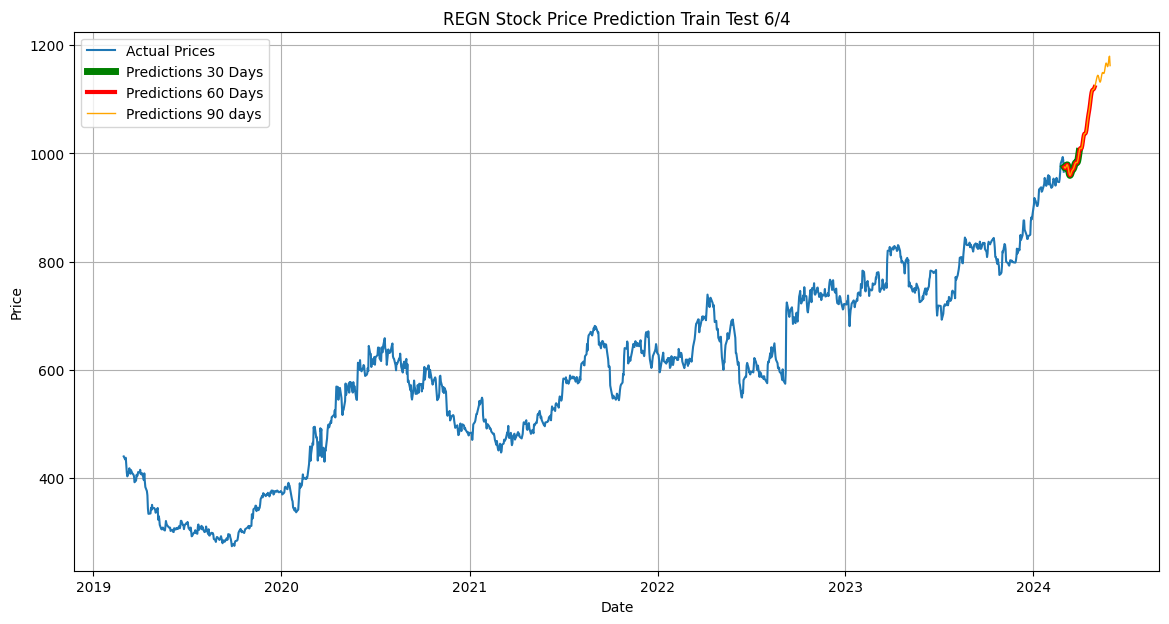

In [15]:
import matplotlib.pyplot as plt
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(original_dates, data['Adj Close'], label='Actual Prices')
plt.plot(future_df90['Date'].iloc[:30], future_df90['Predicted Price'].iloc[:30], label='Predictions 30 Days', color='green', linestyle='-', linewidth=5)
plt.plot(future_df90['Date'].iloc[:60], future_df90['Predicted Price'].iloc[:60], label='Predictions 60 Days', color='red', linestyle='-', linewidth=3)
plt.plot(future_df90['Date'], future_df90['Predicted Price'], label='Predictions 90 days', color='orange', linestyle='-', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('REGN Stock Price Prediction Train Test 6/4')
plt.legend()
plt.grid(True)
plt.show()